<a href="https://colab.research.google.com/github/Daivar/Neural_Style_Transfer/blob/main/%E2%80%9ENeural_Style_Transfer_forest_ipynb%E2%80%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("sims.png", "https://i.pinimg.com/564x/56/59/14/5659148e062d0305e0b326dfd3522d01.jpg")
style_reference_image_path = keras.utils.get_file("forest.jpg", "https://media.istockphoto.com/photos/sun-shining-in-a-forest-picture-id901134626")
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture - same as the content image.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

57344/42934 [========================================] - 0s 0us/step


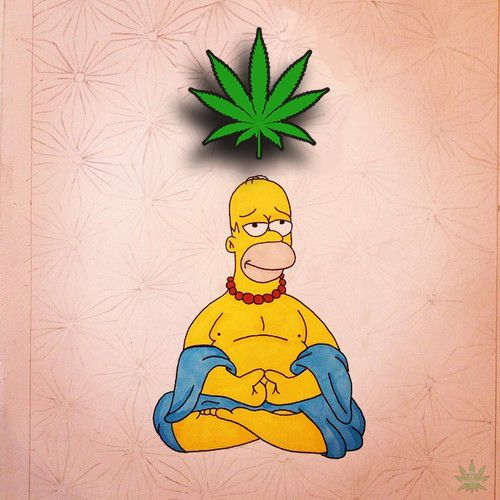

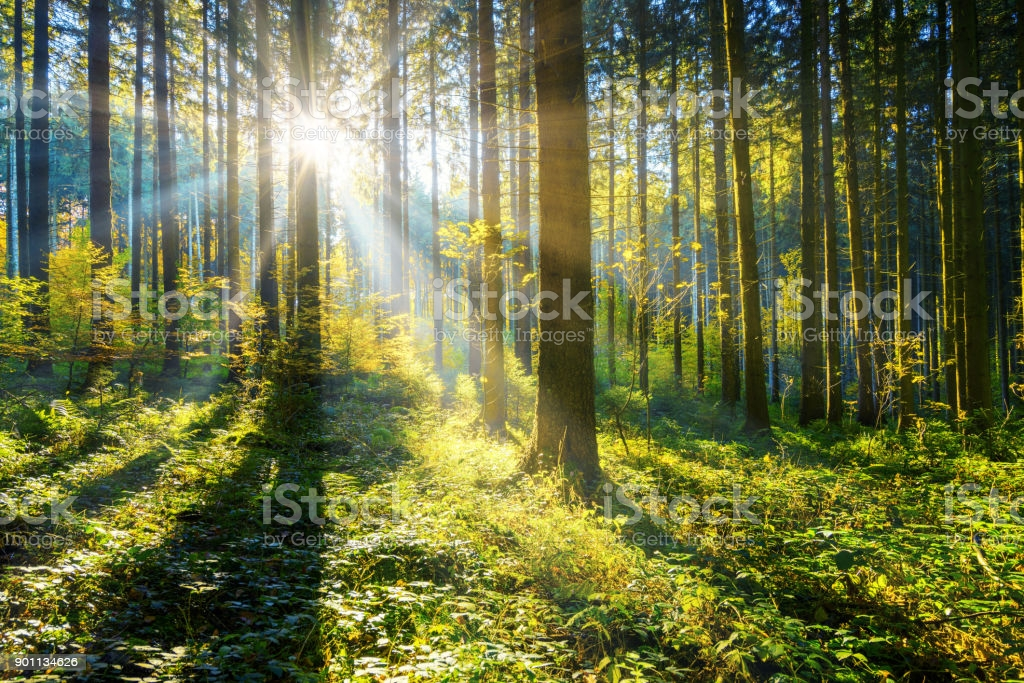

In [255]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [256]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)
    

def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel of 
    # ... the imagenet (not sure if it's the imagenet)
    # ... this is a form of normalization used in the CNN
    # ... durring classification or other tasks
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]  # [[[B, G, R]]]  --> [[[R, G, B]]]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [257]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# The "style loss" is designed to maintain
# .. the style of the reference image in the generated image.
# .. It is based on the gram matrices (which capture style) of
# .. feature maps from the style reference image
# .. and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# An auxiliary loss function
# .. designed to maintain the "content" of the
# .. base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# The 3rd loss function, total variation loss,
# .. designed to keep the generated image locally coherent
# .. (it should help keep similar pixel values when these
# .. pixels are near each other).
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25)) 

In [258]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [259]:
outputs_dict

{'block1_conv1': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 'block3_conv3': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 'block3

In [260]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# The layer to use for the content loss.
content_layer_name = "block5_conv2"

In [261]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the total loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]  # 0 because that is the base_image possition
    combination_features = layer_features[2, :, :, :] # 2 because that is the generated image possition
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [262]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [263]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

# TODO :: 
# /usr/local/lib/python3.6/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
#  FormatterWarning
# <IPython.core.display.Image object>
display(Image(combination_image))

/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

In [264]:
%%time

iterations = 500
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)]) # apply the gradients to the image itself!
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=5195.63
Iteration 200: loss=4341.21
Iteration 300: loss=3984.84
Iteration 400: loss=3775.01
Iteration 500: loss=3630.84
CPU times: user 2min 24s, sys: 2min 15s, total: 4min 40s
Wall time: 4min 40s


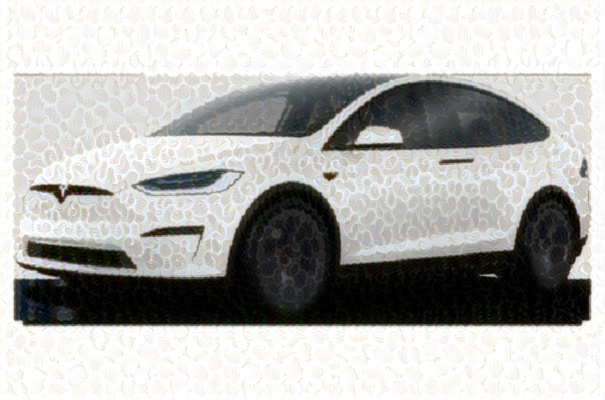

In [229]:
display(Image(result_prefix + "_at_iteration_100.png"))

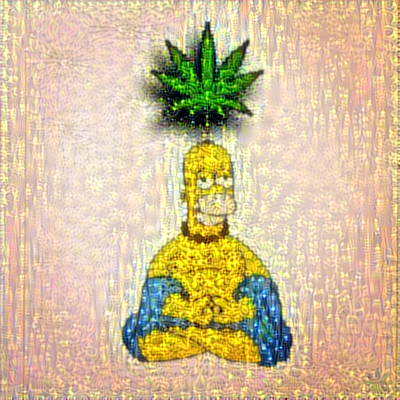

In [265]:
display(Image(result_prefix + "_at_iteration_500.png"))